In [7]:
!pip install --upgrade "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 21.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82


In [8]:
!pip install numpyro dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.8/360.8 kB 15.1 MB/s eta 0:00:00


In [9]:
!pip install arviz

In [10]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

import time

import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
from numpyro.infer import SVI, Trace_ELBO, Predictive
import numpyro.diagnostics

from termcolor import colored

import dill
import pickle
import arviz as az

In [11]:
import jax
print(jax.devices())

[CpuDevice(id=0)]


In [12]:
numpyro.set_host_device_count(4)

In [13]:
# Check the host device count using jax.local_device_count()
host_device_count = jax.local_device_count()
print(f"Host device count: {host_device_count}")

Host device count: 1


#GP Kernel Function

In [ ]:
def dist_euclid(x, z):
    """
    Computes Eucledian Distance Between Regions. This function is used by
    exp_sq_kernel function (kernel function for gaussian processes)
    """
    x = jnp.array(x) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    z = jnp.array(z) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    n_x, m = x.shape # 7304 , 2
    n_z, m_z = z.shape # 7304 , 2
    assert m == m_z
    delta = jnp.zeros((n_x,n_z)) #(ngrid_pts,ngrid_pts) <- i.e (7304,7304)
    for d in jnp.arange(m):
        x_d = x[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        z_d = z[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        delta += (x_d[:,jnp.newaxis] - z_d)**2 # (7304,7304)

    return jnp.sqrt(delta) #(7304,7304)

In [ ]:
def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z) #(7304, 7304)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k # (ngrid_pts, ngrid_pts) <- (7304,7304)


#Aggregation Functions

In [ ]:
def M_g(M, g):
    '''
    - $M$ is a matrix with binary entries $m_{ij},$ showing whether point $j$ is in polygon $i$
    - $g$ is a vector of GP draws over grid
    - $maltmul(M, g)$ gives a vector of sums over each polygon
    '''
    M = jnp.array(M)
    g = jnp.array(g).T
    return(jnp.matmul(M, g))

#Aggregated Prevalence Model - must edit this to include HDI, population density



In [ ]:
def prev_model_gp_aggr(args):
    """Dengue prevalence model with a Gaussian Process"""

    x = args["x"]  # Spatial grid points: (num_grid_points, 2)
    gp_kernel = args["gp_kernel"]  # Gaussian Process kernel
    noise = args["noise"]
    jitter = args["jitter"]

    pop_density = args["pop_density"]  # (num_districts,)
    hdi = args["hdi"]  # (num_districts,)
    M = args["M"]  # (num_districts, num_grid_points) aggregation matrix
    total_cases = args["total_cases"]
    total_population = args["total_population"]

    # GP hyperparameters
    kernel_length = numpyro.sample("kernel_length", args["kernel_length"])
    kernel_var = numpyro.sample("kernel_var", args["kernel_var"])

    # GP Kernel and Sample
    k = gp_kernel(x, x, kernel_var, kernel_length, noise, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))  # (num_grid_points,)

    # Aggregate GP values to district level
    gp_aggr = numpyro.deterministic("gp_aggr", M @ f)  # (num_districts,)

    # Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(0, 1))  # Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  # Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  # Effect of HDI

    # Linear predictor
    lp = b0 + gp_aggr + b_pop_density * pop_density + b_hdi * hdi  # (num_districts,)

    # Prevalence probability
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))  # (num_districts,)

    # Binomial likelihood
    observed_cases = numpyro.sample(
        "observed_cases",
        dist.Binomial(total_count=total_population, probs=theta),
        obs=total_cases
    )

    return observed_cases


#Load Data

In [ ]:
# Lat/Lon Values of artificial grid
x = np.load("lat_lon_x_all.npy")

# combined regional data
pol_pts_all = np.load("pol_pts_all.npy")
pt_which_pol_all = np.load("pt_which_pol_all.npy")

#combine the dataframes
df_combined = gpd.read_file("final_combined_divisions.shp")

In [ ]:
#check columns
df_combined.head()

,District,x,y,Year,Area_sq_km,HDI,Cases,Population,Pop_densit,geometry
0,BANDUNG,107.610841,-7.099969,2020,1767.96,72.39,9180,14495160,8198.805403,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
1,BANDUNG,107.610841,-7.099969,2021,1767.96,72.73,8008,14662620,8293.524740,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
2,BANDUNG,107.610841,-7.099969,2022,1767.96,73.16,16764,14830092,8388.250865,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
3,BANDUNG,107.610841,-7.099969,2023,1767.96,73.74,4020,14997564,8482.976990,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
4,BANDUNG BARAT,107.414953,-6.897056,2020,1305.77,68.08,3864,7153344,5478.257273,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688..."


In [ ]:
#rename Pop_densit to Pop_density
df_combined = df_combined.rename(columns={'Pop_densit': 'Pop_density'})

#check head again
df_combined.head()

,District,x,y,Year,Area_sq_km,HDI,Cases,Population,Pop_density,geometry
0,BANDUNG,107.610841,-7.099969,2020,1767.96,72.39,9180,14495160,8198.805403,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
1,BANDUNG,107.610841,-7.099969,2021,1767.96,72.73,8008,14662620,8293.524740,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
2,BANDUNG,107.610841,-7.099969,2022,1767.96,73.16,16764,14830092,8388.250865,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
3,BANDUNG,107.610841,-7.099969,2023,1767.96,73.74,4020,14997564,8482.976990,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
4,BANDUNG BARAT,107.414953,-6.897056,2020,1305.77,68.08,3864,7153344,5478.257273,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688..."


#Vars needed to be changed (change according to the agg prevalence model parameters)

In [ ]:
M = jnp.array(pol_pts_all)
pop_density = jnp.array(df_combined["Pop_density"])
hdi = jnp.array(df_combined["HDI"])
test_cases = jnp.array(df_combined["Population"])
cases = jnp.array(df_combined["Cases"])

In [ ]:
#print the shape of all the vars above
print(M.shape)
print(pop_density.shape)
print(hdi.shape)
print(test_cases.shape)
print(cases.shape)
print(x.shape)
print(pt_which_pol_all.shape)

(96, 7304)
(96,)
(96,)
(96,)
(96,)
(7304, 2)
(7304,)


#Agg GP Model

In [ ]:
args = {
        "x" : jnp.array(x), # Lat/lon vals of grid points # Shape (num_districts, 2)
        "gp_kernel" : exp_sq_kernel,
        "jitter" : 1e-4,
        "noise" : 1e-4,
        "M" : jnp.array(pol_pts_all), # Aggregation matrix # Shape (num_districts, num_districts)
        # GP Kernel Hyperparams
        "kernel_length" : dist.InverseGamma(3,3), #(,)
        "kernel_var" : dist.HalfNormal(0.05),
        "pop_density": jnp.array(df_combined["Pop_density"]), # Shape (num_districts,)
        "hdi": jnp.array(df_combined["HDI"]), # Shape (num_districts, 2)
        "total_cases" : jnp.array(df_combined["Cases"]),
        "total_population" : jnp.array(df_combined["Population"])
    }


#Run MCMC

In [ ]:
# 🔹 Random keys
run_key, predict_key = random.split(random.PRNGKey(3))

# 🔹 MCMC settings
n_warm = 1000
n_samples = 2000
n_chains = 3


NameError: name 'random' is not defined

In [14]:
# 🔹 Directory for saving
save_dir = "model_weights"
os.makedirs(save_dir, exist_ok=True)

#Save Model

In [ ]:
# 🔹 Run MCMC for each chain separately to prevent total loss on crash
for chain_id in range(n_chains):
    print(f"\nRunning Chain {chain_id + 1}/{n_chains}...")

    # Generate a separate key for each chain
    chain_run_key = random.split(run_key, n_chains)[chain_id]

    # Initialize MCMC with controlled step size
    mcmc = MCMC(NUTS(prev_model_gp_aggr),
        num_warmup=n_warm,
        num_samples=n_samples,
        num_chains=1)
    # Run the chain
    start = time.time()
    mcmc.run(chain_run_key, args)
    end = time.time()
    t_elapsed_min = round((end - start) / 60)

    # 🔹 Save after each chain completes
    f_path = f"{save_dir}/aggGP_chain{chain_id}_nsamples_{n_samples}_tt{t_elapsed_min}min.pkl"
    with open(f_path, "wb") as file:
        dill.dump(mcmc, file)

    print(f"✅ Saved Chain {chain_id + 1} to {f_path}")
    print(f"⏳ Time taken: {t_elapsed_min} min\n")



Running Chain 1/4...


sample: 100%|██████████| 3000/3000 [4:28:10<00:00,  5.36s/it, 4 steps of size 4.18e-02. acc. prob=0.86]


✅ Saved Chain 1 to model_weights/aggGP_chain0_nsamples_2000_tt268min.pkl
⏳ Time taken: 268 min


Running Chain 2/4...


sample: 100%|██████████| 3000/3000 [3:10:39<00:00,  3.81s/it, 4 steps of size 5.42e-02. acc. prob=0.85]


✅ Saved Chain 2 to model_weights/aggGP_chain1_nsamples_2000_tt191min.pkl
⏳ Time taken: 191 min


Running Chain 3/4...


sample: 100%|██████████| 3000/3000 [3:23:12<00:00,  4.06s/it, 62 steps of size 5.22e-02. acc. prob=0.87]


✅ Saved Chain 3 to model_weights/aggGP_chain2_nsamples_2000_tt203min.pkl
⏳ Time taken: 203 min


Running Chain 4/4...


warmup:   6%|▌         | 172/3000 [3:02:56<23:53:48, 30.42s/it, 1 steps of size 3.34e-07. acc. prob=0.73]

In [ ]:
#chain 4 crashed before finished training, so run it separately in another machine
# Generate a separate key for each chain
chain_run_key = random.split(run_key, n_chains)[3]

# Initialize MCMC
mcmc = MCMC(NUTS(prev_model_gp_aggr),
        num_warmup=n_warm,
        num_samples=n_samples,
        num_chains=1)


# Run the chain
start = time.time()
mcmc.run(chain_run_key, args)
end = time.time()
t_elapsed_min = round((end - start) / 60)

# 🔹 Save after each chain completes
f_path = f"{save_dir}/aggGP_chain{chain_id}_nsamples_{n_samples}_tt{t_elapsed_min}min.pkl"
with open(f_path, "wb") as file:
    dill.dump(mcmc, file)

print(f"✅ Saved Chain {chain_id + 1} to {f_path}")
print(f"⏳ Time taken: {t_elapsed_min} min\n")

In [ ]:
# 🔹 Print total elapsed time
total_end = time.time()
print("\nMCMC Total elapsed time:", round(total_end), "s")
print("MCMC Total elapsed time:", round(total_end / 60), "min")
print("MCMC Total elapsed time:", round(total_end / (60 * 60)), "h")

##Combine the MCMC saved files tgt

In [15]:
#load the files
save_dir = "model_weights"
n_samples = 2000  # Adjust based on your settings

# Load MCMC objects
mcmc_list = []
for chain_id in range(3):  # Since you only have chains 0 to 2
    f_path = f"{save_dir}/aggGP_chain{chain_id}_nsamples_{n_samples}_tt*.pkl"

    # Find the correct file (in case time differs)
    matching_files = [f for f in os.listdir(save_dir) if f.startswith(f"aggGP_chain{chain_id}_nsamples_{n_samples}_tt")]

    if matching_files:
        with open(os.path.join(save_dir, matching_files[0]), "rb") as file:
            mcmc_list.append(dill.load(file))
    else:
        print(f"Missing Chain {chain_id} file!")



In [16]:
# Extract samples from each MCMC object
samples_list = [mcmc.get_samples() for mcmc in mcmc_list]

# Convert to NumPy array and add a new chain dimension
combined_samples = {k: np.stack([s[k] for s in samples_list], axis=0) for k in samples_list[0].keys()}

# Convert to ArviZ InferenceData format
idata = az.from_dict(posterior=combined_samples)

##Check diagnostics

/usr/local/lib/python3.11/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'b0'}>, <Axes: title={'center': 'b0'}>],
       [<Axes: title={'center': 'b_hdi'}>,
        <Axes: title={'center': 'b_hdi'}>],
       [<Axes: title={'center': 'b_pop_density'}>,
        <Axes: title={'center': 'b_pop_density'}>],
       [<Axes: title={'center': 'f'}>, <Axes: title={'center': 'f'}>],
       [<Axes: title={'center': 'gp_aggr'}>,
        <Axes: title={'center': 'gp_aggr'}>],
       [<Axes: title={'center': 'kernel_length'}>,
        <Axes: title={'center': 'kernel_length'}>],
       [<Axes: title={'center': 'kernel_var'}>,
        <Axes: title={'center': 'kernel_var'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

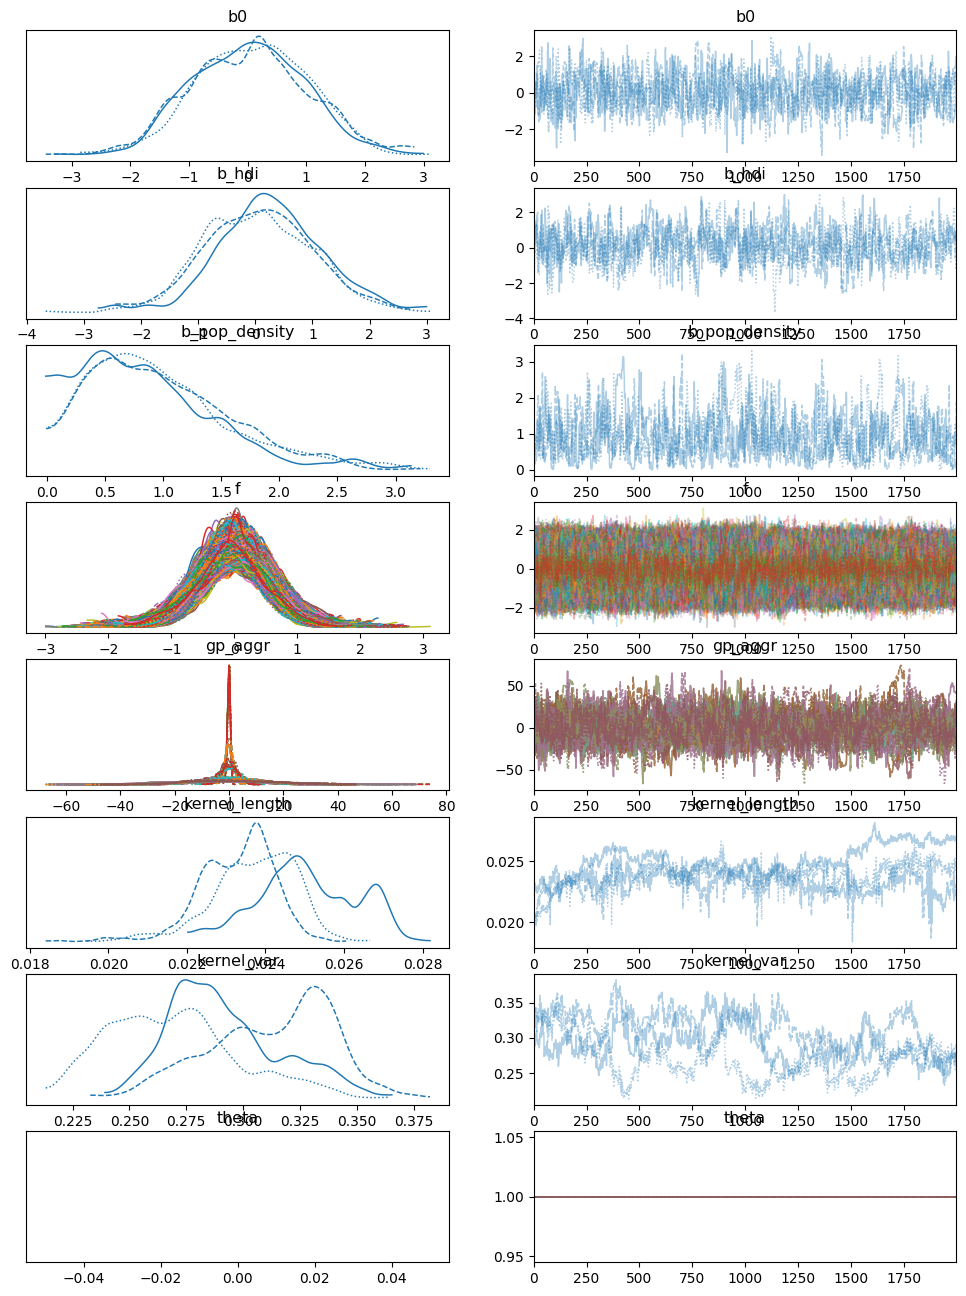

In [17]:
#trace plot (check mixing)
az.plot_trace(idata)

/usr/local/lib/python3.11/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (7501) in plot_rank, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'b0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'b_hdi'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'b_pop_density'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'f\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'f\n5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n6'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n7'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'f\n8'}, xla

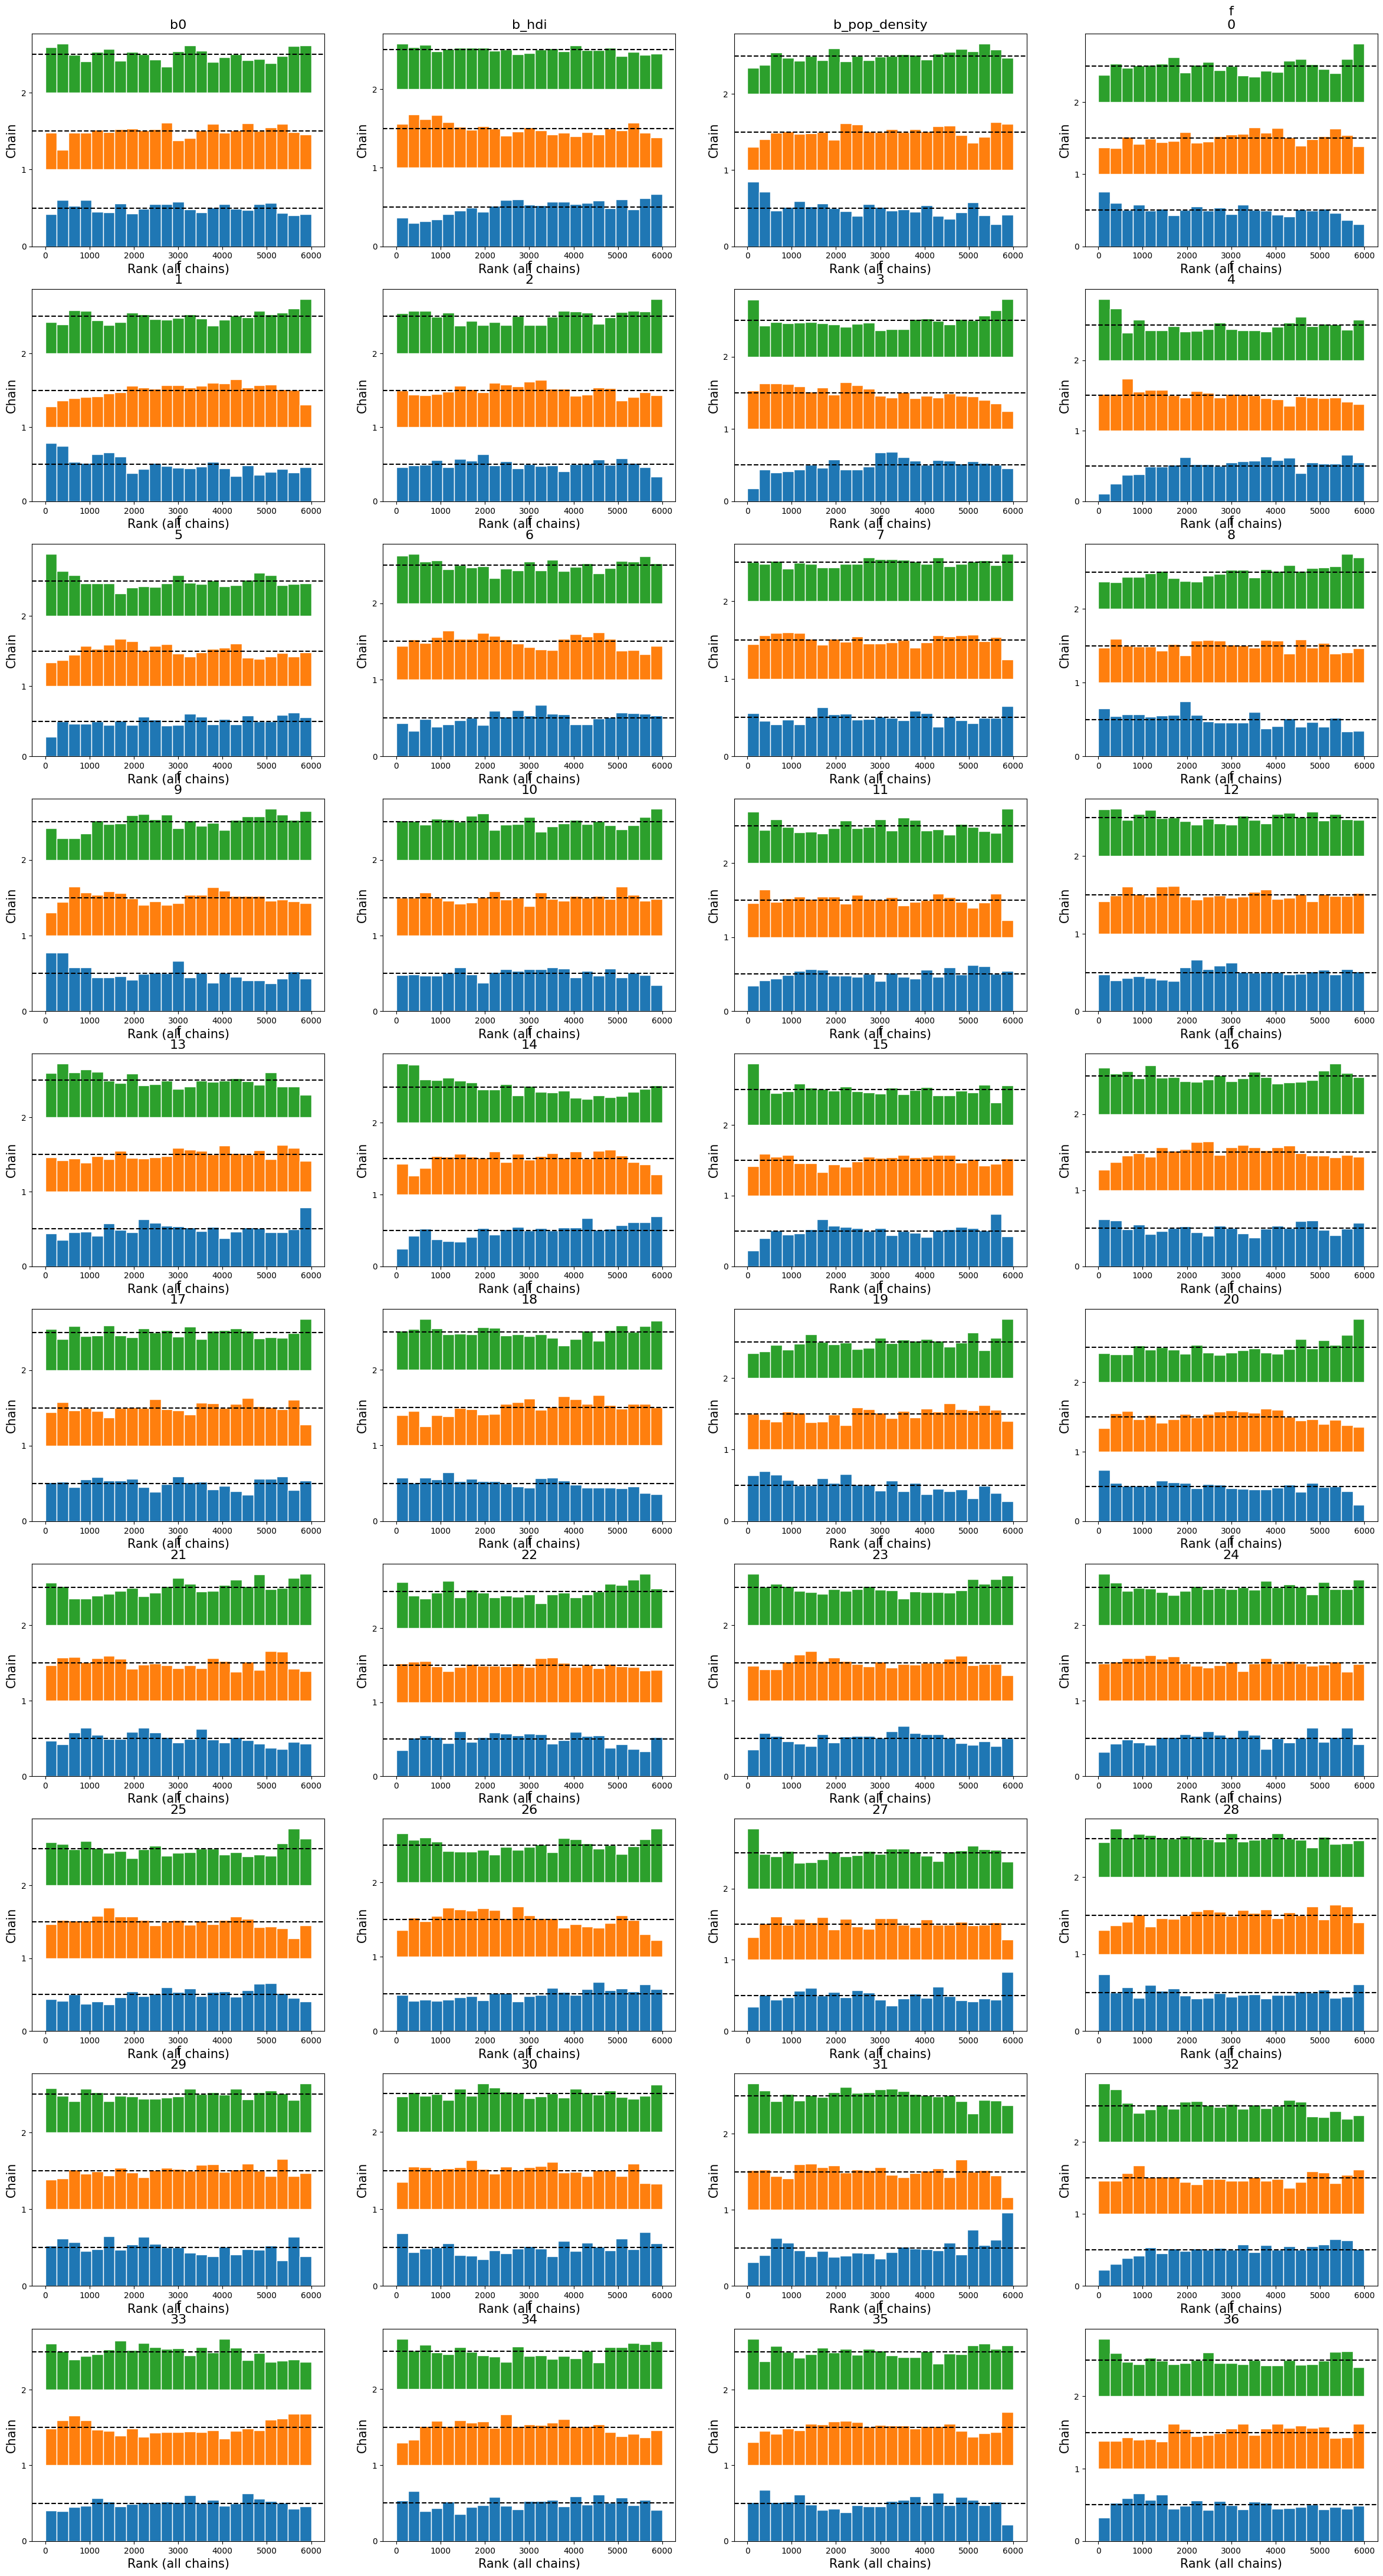

In [18]:
#rank plot (ensure good mixing across chains)
az.plot_rank(idata)

In [19]:
#rhat (check diagnostics)
print(az.rhat(idata))

<xarray.Dataset> Size: 120kB
Dimensions:        (f_dim_0: 7304, gp_aggr_dim_0: 96, theta_dim_0: 96)
Coordinates:
  * f_dim_0        (f_dim_0) int64 58kB 0 1 2 3 4 5 ... 7299 7300 7301 7302 7303
  * gp_aggr_dim_0  (gp_aggr_dim_0) int64 768B 0 1 2 3 4 5 ... 90 91 92 93 94 95
  * theta_dim_0    (theta_dim_0) int64 768B 0 1 2 3 4 5 6 ... 90 91 92 93 94 95
Data variables:
    b0             float64 8B 1.009
    b_hdi          float64 8B 1.014
    b_pop_density  float64 8B 1.008
    f              (f_dim_0) float64 58kB 1.021 1.026 1.016 ... 1.008 1.003
    gp_aggr        (gp_aggr_dim_0) float64 768B 1.009 1.009 ... 1.007 1.007
    kernel_length  float64 8B 1.343
    kernel_var     float64 8B 1.379
    theta          (theta_dim_0) float64 768B nan nan nan nan ... nan nan nan


/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [20]:
#effective sample size (ESS, >1000 ideally)
print(az.ess(idata))

<xarray.Dataset> Size: 120kB
Dimensions:        (f_dim_0: 7304, gp_aggr_dim_0: 96, theta_dim_0: 96)
Coordinates:
  * f_dim_0        (f_dim_0) int64 58kB 0 1 2 3 4 5 ... 7299 7300 7301 7302 7303
  * gp_aggr_dim_0  (gp_aggr_dim_0) int64 768B 0 1 2 3 4 5 ... 90 91 92 93 94 95
  * theta_dim_0    (theta_dim_0) int64 768B 0 1 2 3 4 5 6 ... 90 91 92 93 94 95
Data variables:
    b0             float64 8B 673.9
    b_hdi          float64 8B 526.3
    b_pop_density  float64 8B 318.9
    f              (f_dim_0) float64 58kB 289.2 225.9 246.2 ... 348.0 450.8
    gp_aggr        (gp_aggr_dim_0) float64 768B 203.4 203.4 ... 231.3 231.3
    kernel_length  float64 8B 7.071
    kernel_var     float64 8B 6.709
    theta          (theta_dim_0) float64 768B 6e+03 6e+03 6e+03 ... 6e+03 6e+03


In [21]:
# Extract posterior samples (already combined)
pos_samples = idata.posterior

# Print MCMC summary
print(az.summary(idata, var_names=["gp_aggr", "kernel_length", "kernel_var"]))

# Compute ESS and R-hat diagnostics
ss = numpyro.diagnostics.summary(combined_samples)

# Compute and print diagnostics
r = np.mean(ss["gp_aggr"]["n_eff"])
print(f"Average ESS for all aggGP effects : {round(r)}")
print(f"Max r_hat for all aggGP effects : {round(np.max(ss['gp_aggr']['r_hat']),2)}")
print(f"kernel_length R-hat : {round(ss['kernel_length']['r_hat'], 2)}")
print(f"kernel_var R-hat : {round(ss['kernel_var']['r_hat'],2)}")

                mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
gp_aggr[0]    -0.954  13.291 -25.145   27.175      0.984    0.727     203.0   
gp_aggr[1]    -0.954  13.291 -25.145   27.175      0.984    0.727     203.0   
gp_aggr[2]    -0.954  13.291 -25.145   27.175      0.984    0.727     203.0   
gp_aggr[3]    -0.954  13.291 -25.145   27.175      0.984    0.727     203.0   
gp_aggr[4]    -0.997  10.636 -20.577   19.204      0.842    0.596     160.0   
...              ...     ...     ...      ...        ...      ...       ...   
gp_aggr[93]    0.745  15.582 -25.529   32.934      1.040    0.736     231.0   
gp_aggr[94]    0.745  15.582 -25.529   32.934      1.040    0.736     231.0   
gp_aggr[95]    0.745  15.582 -25.529   32.934      1.040    0.736     231.0   
kernel_length  0.024   0.001   0.022    0.027      0.001    0.000       7.0   
kernel_var     0.291   0.032   0.234    0.348      0.013    0.009       7.0   

               ess_tail  r_hat  
gp_aggr[0]        